In [1]:
import requests
import pandas as pd
import certifi
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_regression, SelectFromModel, RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score 

## Fetching the Data

In [2]:
# Define the URL and column names
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

# Fetch the data from the URL
response = requests.get(url, verify=certifi.where())
response.raise_for_status()

# Load the data into a pandas DataFrame
data = pd.read_csv(StringIO(response.text), names=columns, na_values="?")

# Convert numeric columns
data["ca"] = pd.to_numeric(data["ca"], errors='coerce')
data["thal"] = pd.to_numeric(data["thal"], errors='coerce')

# Display basic info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0   

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [5]:
# Convert 'target' column to numeric (just in case)
data['target'] = pd.to_numeric(data['target'], errors='coerce')

# Convert target values: 1 if > 0, else 0
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

# Display the value counts
print(data['target'].value_counts())

target
0    164
1    139
Name: count, dtype: int64


## Exploratory Data Analysis

In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [8]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']


In [9]:
# Display unique values and count of missing values
print("Unique values in 'ca':", data['ca'].unique())
print("Missing values in 'ca':", data['ca'].isna().sum())

print("Unique values in 'thal':", data['thal'].unique())
print("Missing values in 'thal':", data['thal'].isna().sum())


Unique values in 'ca': [ 0.  3.  2.  1. nan]
Missing values in 'ca': 4
Unique values in 'thal': [ 6.  3.  7. nan]
Missing values in 'thal': 2


In [10]:
# Filling numerical column with median
data['ca'] = data['ca'].fillna(data['ca'].median())

# Filling categorical column with mode
data['thal'] = data['thal'].fillna(data['thal'].mode()[0])

# Verify missing values are handled
print("Missing values in 'ca':", data['ca'].isna().sum())
print("Missing values in 'thal':", data['thal'].isna().sum())



Missing values in 'ca': 0
Missing values in 'thal': 0


In [11]:
# Print correlation matrix with better formatting
print("\nCorrelation Matrix:\n", data.corr().round(2))


Correlation Matrix:
            age   sex    cp  trestbps  chol   fbs  restecg  thalach  exang  \
age       1.00 -0.10  0.10      0.28  0.21  0.12     0.15    -0.39   0.09   
sex      -0.10  1.00  0.01     -0.06 -0.20  0.05     0.02    -0.05   0.15   
cp        0.10  0.01  1.00     -0.04  0.07 -0.04     0.07    -0.33   0.38   
trestbps  0.28 -0.06 -0.04      1.00  0.13  0.18     0.15    -0.05   0.06   
chol      0.21 -0.20  0.07      0.13  1.00  0.01     0.17    -0.00   0.06   
fbs       0.12  0.05 -0.04      0.18  0.01  1.00     0.07    -0.01   0.03   
restecg   0.15  0.02  0.07      0.15  0.17  0.07     1.00    -0.08   0.08   
thalach  -0.39 -0.05 -0.33     -0.05 -0.00 -0.01    -0.08     1.00  -0.38   
exang     0.09  0.15  0.38      0.06  0.06  0.03     0.08    -0.38   1.00   
oldpeak   0.20  0.10  0.20      0.19  0.05  0.01     0.11    -0.34   0.29   
slope     0.16  0.04  0.15      0.12 -0.00  0.06     0.13    -0.39   0.26   
ca        0.37  0.09  0.23      0.10  0.12  0.14     0

Missing values in each column before handling:
sex        0
cp         0
fbs        0
restecg    0
exang      0
slope      0
thal       0
dtype: int64

Missing values after filling:
sex        0
cp         0
fbs        0
restecg    0
exang      0
slope      0
thal       0
dtype: int64

Data types of categorical columns before encoding:
sex        float64
cp         float64
fbs        float64
restecg    float64
exang      float64
slope      float64
thal       float64
dtype: object

Correlation matrix:
              sex        cp       fbs   restecg     exang     slope      thal
sex      1.000000  0.122660  0.047862  0.055217 -0.146201  0.037533 -0.215039
cp       0.122660  1.000000  0.023976  0.135782 -0.314993  0.250500 -0.167571
fbs      0.047862  0.023976  1.000000  0.081538 -0.025665  0.059894  0.011209
restecg  0.055217  0.135782  0.081538  1.000000 -0.066333  0.086880 -0.010262
exang   -0.146201 -0.314993 -0.025665 -0.066333  1.000000 -0.257748  0.225508
slope    0.037533  0.25050

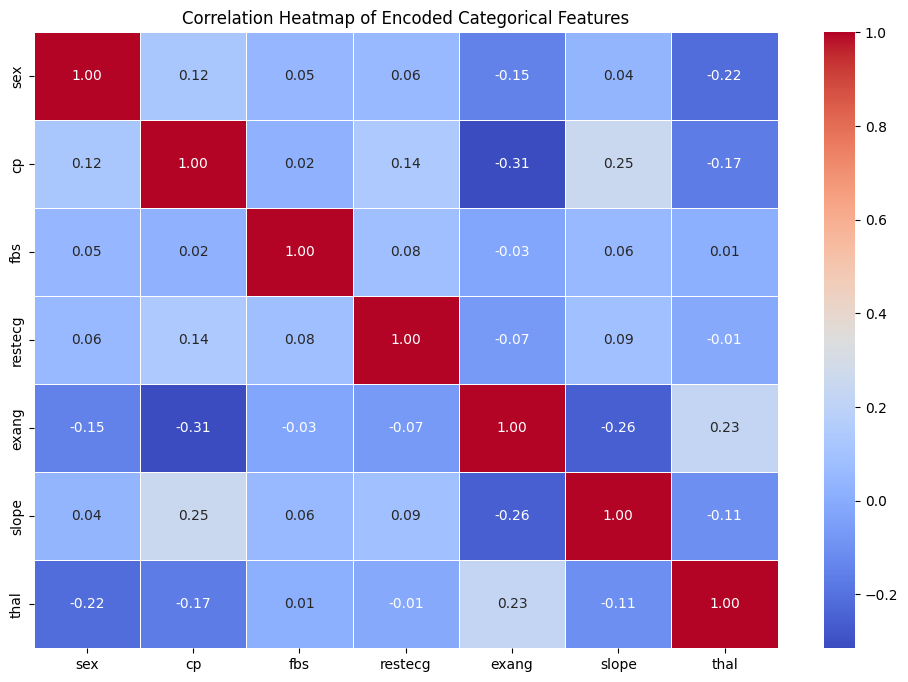

In [12]:
# List of categorical columns
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Select categorical data (use .copy() to avoid chained assignment warnings)
categorical_data = data[categorical_columns].copy()

# Check for missing values
print("Missing values in each column before handling:")
print(categorical_data.isnull().sum())

# Fill missing values with the mode of each column safely (no inplace=True)
for col in categorical_columns:
    mode_value = categorical_data[col].mode()[0]
    categorical_data[col] = categorical_data[col].fillna(mode_value)

# Verify missing values are handled
print("\nMissing values after filling:")
print(categorical_data.isnull().sum())

# Verify data types
print("\nData types of categorical columns before encoding:")
print(categorical_data.dtypes)

# Convert categorical data to numerical encoding using pd.factorize
categorical_encoded = categorical_data.apply(lambda x: pd.factorize(x)[0])

# Calculate the correlation matrix
corr_matrix = categorical_encoded.corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Encoded Categorical Features")
plt.show()


Missing values in each column:
sex        0
cp         0
fbs        0
restecg    0
exang      0
slope      0
thal       0
dtype: int64
Data types of each column:
sex        float64
cp         float64
fbs        float64
restecg    float64
exang      float64
slope      float64
thal       float64
dtype: object
Correlation matrix:
              sex        cp       fbs   restecg     exang     slope      thal
sex      1.000000  0.122660  0.047862  0.055217 -0.146201  0.037533 -0.215039
cp       0.122660  1.000000  0.023976  0.135782 -0.314993  0.250500 -0.167571
fbs      0.047862  0.023976  1.000000  0.081538 -0.025665  0.059894  0.011209
restecg  0.055217  0.135782  0.081538  1.000000 -0.066333  0.086880 -0.010262
exang   -0.146201 -0.314993 -0.025665 -0.066333  1.000000 -0.257748  0.225508
slope    0.037533  0.250500  0.059894  0.086880 -0.257748  1.000000 -0.106310
thal    -0.215039 -0.167571  0.011209 -0.010262  0.225508 -0.106310  1.000000


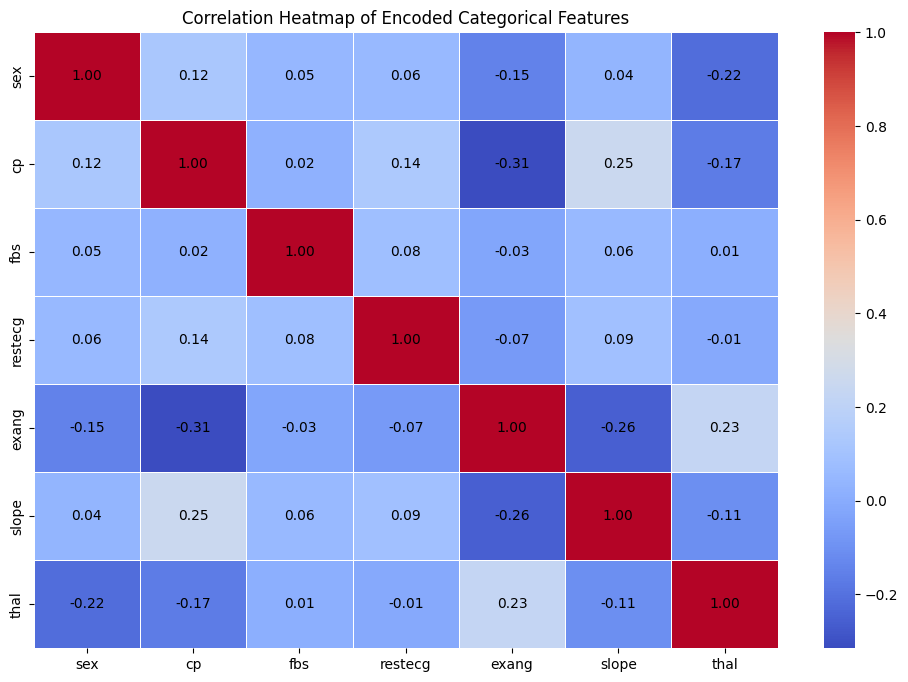

In [13]:
# List of categorical columns
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Select the categorical data
categorical_data = data[categorical_columns]

# Check for missing values
print("Missing values in each column:")
print(categorical_data.isnull().sum())

# Handle missing values if any
categorical_data = categorical_data.dropna()

# Verify data types
print("Data types of each column:")
print(categorical_data.dtypes)

# Convert categorical data to numerical encoding for correlation analysis
categorical_encoded = categorical_data.apply(lambda x: pd.factorize(x)[0])

# Calculate the correlation matrix
corr_matrix = categorical_encoded.corr()
print("Correlation matrix:")
print(corr_matrix)

# Plot the heatmap with annotations that are more visible
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"color": "black", "size": 10}
)
plt.title("Correlation Heatmap of Encoded Categorical Features")
plt.show()

In [14]:
print(data.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       1  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [15]:
print(data.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [16]:
print(data.dtypes)


age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype: object


In [17]:
numerical_data = data.select_dtypes(include=[np.number])


# Check for non-numeric values in numerical data
for column in numerical_data.columns:
    print(f"{column} unique values:", numerical_data[column].unique())

age unique values: [63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76.]
sex unique values: [1. 0.]
cp unique values: [1. 4. 3. 2.]
trestbps unique values: [145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 114. 164.]
chol unique values: [233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 182. 303. 265. 309.
 307. 249. 186. 341. 183. 407

In [18]:
import numpy as np

# Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

# Convert all numerical columns to proper numeric format
numerical_data = data.drop(columns=categorical_columns).apply(pd.to_numeric, errors='coerce')

# Check if there are still missing values
print(numerical_data.isnull().sum())

# Option 1: Drop rows with missing values (if there are very few missing)
numerical_data.dropna(inplace=True)

# Option 2: Fill missing values (if you don't want to drop data)
# numerical_data.fillna(numerical_data.median(), inplace=True)

age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
ca          0
target      0
dtype: int64


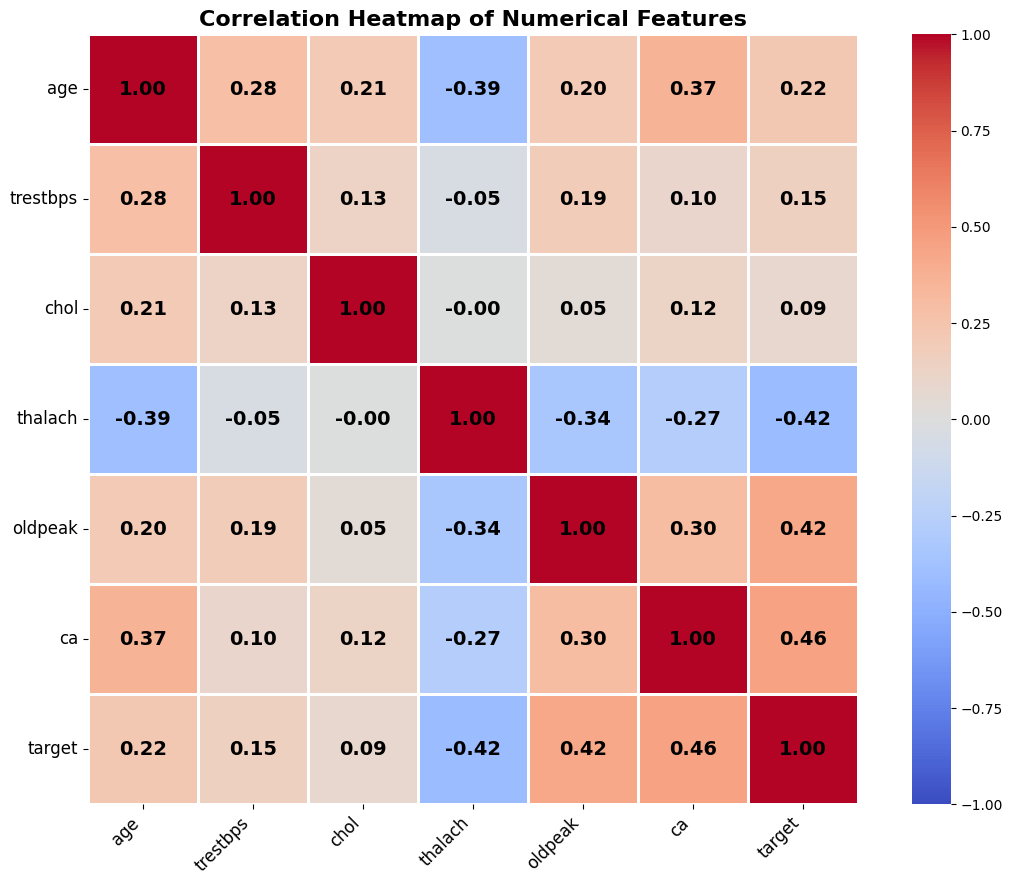

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(numerical_data.corr(), 
            annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=1, annot_kws={"size": 14, "color": "black", "weight": "bold"}, 
            vmin=-1, vmax=1, square=True)

plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12, rotation=0)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight='bold')

plt.show()


In [20]:
# Get unique values for each column
unique_values = {col: data[col].unique() for col in data.columns}

# Display unique values
for column, values in unique_values.items():
    print(f"Column '{column}' unique values: {values}\n")

Column 'age' unique values: [63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76.]

Column 'sex' unique values: [1. 0.]

Column 'cp' unique values: [1. 4. 3. 2.]

Column 'trestbps' unique values: [145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 114. 164.]

Column 'chol' unique values: [233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 

In [21]:
# Filter out rows where 'ca' or 'thal' columns contain '?' values
data = data[(data['ca'] != '?') & (data['thal'] != '?')]

In [22]:
# Drop rows where 'ca' (number of major vessels colored by flouroscopy) 
# or 'thal' (thalassemia) columns have missing values (NaN)
data = data.dropna(subset=['ca', 'thal'])

In [23]:
unique_values

{'age': array([63., 67., 37., 41., 56., 62., 57., 53., 44., 52., 48., 54., 49.,
        64., 58., 60., 50., 66., 43., 40., 69., 59., 42., 55., 61., 65.,
        71., 51., 46., 45., 39., 68., 47., 34., 35., 29., 70., 77., 38.,
        74., 76.]),
 'sex': array([1., 0.]),
 'cp': array([1., 4., 3., 2.]),
 'trestbps': array([145., 160., 120., 130., 140., 172., 150., 110., 132., 117., 135.,
        112., 105., 124., 125., 142., 128., 170., 155., 104., 180., 138.,
        108., 134., 122., 115., 118., 100., 200.,  94., 165., 102., 152.,
        101., 126., 174., 148., 178., 158., 192., 129., 144., 123., 136.,
        146., 106., 156., 154., 114., 164.]),
 'chol': array([233., 286., 229., 250., 204., 236., 268., 354., 254., 203., 192.,
        294., 256., 263., 199., 168., 239., 275., 266., 211., 283., 284.,
        224., 206., 219., 340., 226., 247., 167., 230., 335., 234., 177.,
        276., 353., 243., 225., 302., 212., 330., 175., 417., 197., 198.,
        290., 253., 172., 273., 213., 3

In [24]:
# Replace '?' with NaN in the specified columns
data['ca'] = data['ca'].replace('?', np.nan)
data['thal'] = data['thal'].replace('?', np.nan)

# Convert the columns to numeric, coercing any remaining issues
data['ca'] = pd.to_numeric(data['ca'], errors='coerce')
data['thal'] = pd.to_numeric(data['thal'], errors='coerce')

# Drop rows where 'ca' or 'thal' contain NaN values
data.dropna(subset=['ca', 'thal'], inplace=True)

# Convert to integers if needed
data['ca'] = data['ca'].astype(int)
data['thal'] = data['thal'].astype(int)

# Check results
print(data[['ca', 'thal']].head())

   ca  thal
0   0     6
1   3     3
2   2     7
3   0     3
4   0     3


In [25]:
print(data['ca'].unique())
print(data['thal'].unique())

[0 3 2 1]
[6 3 7]


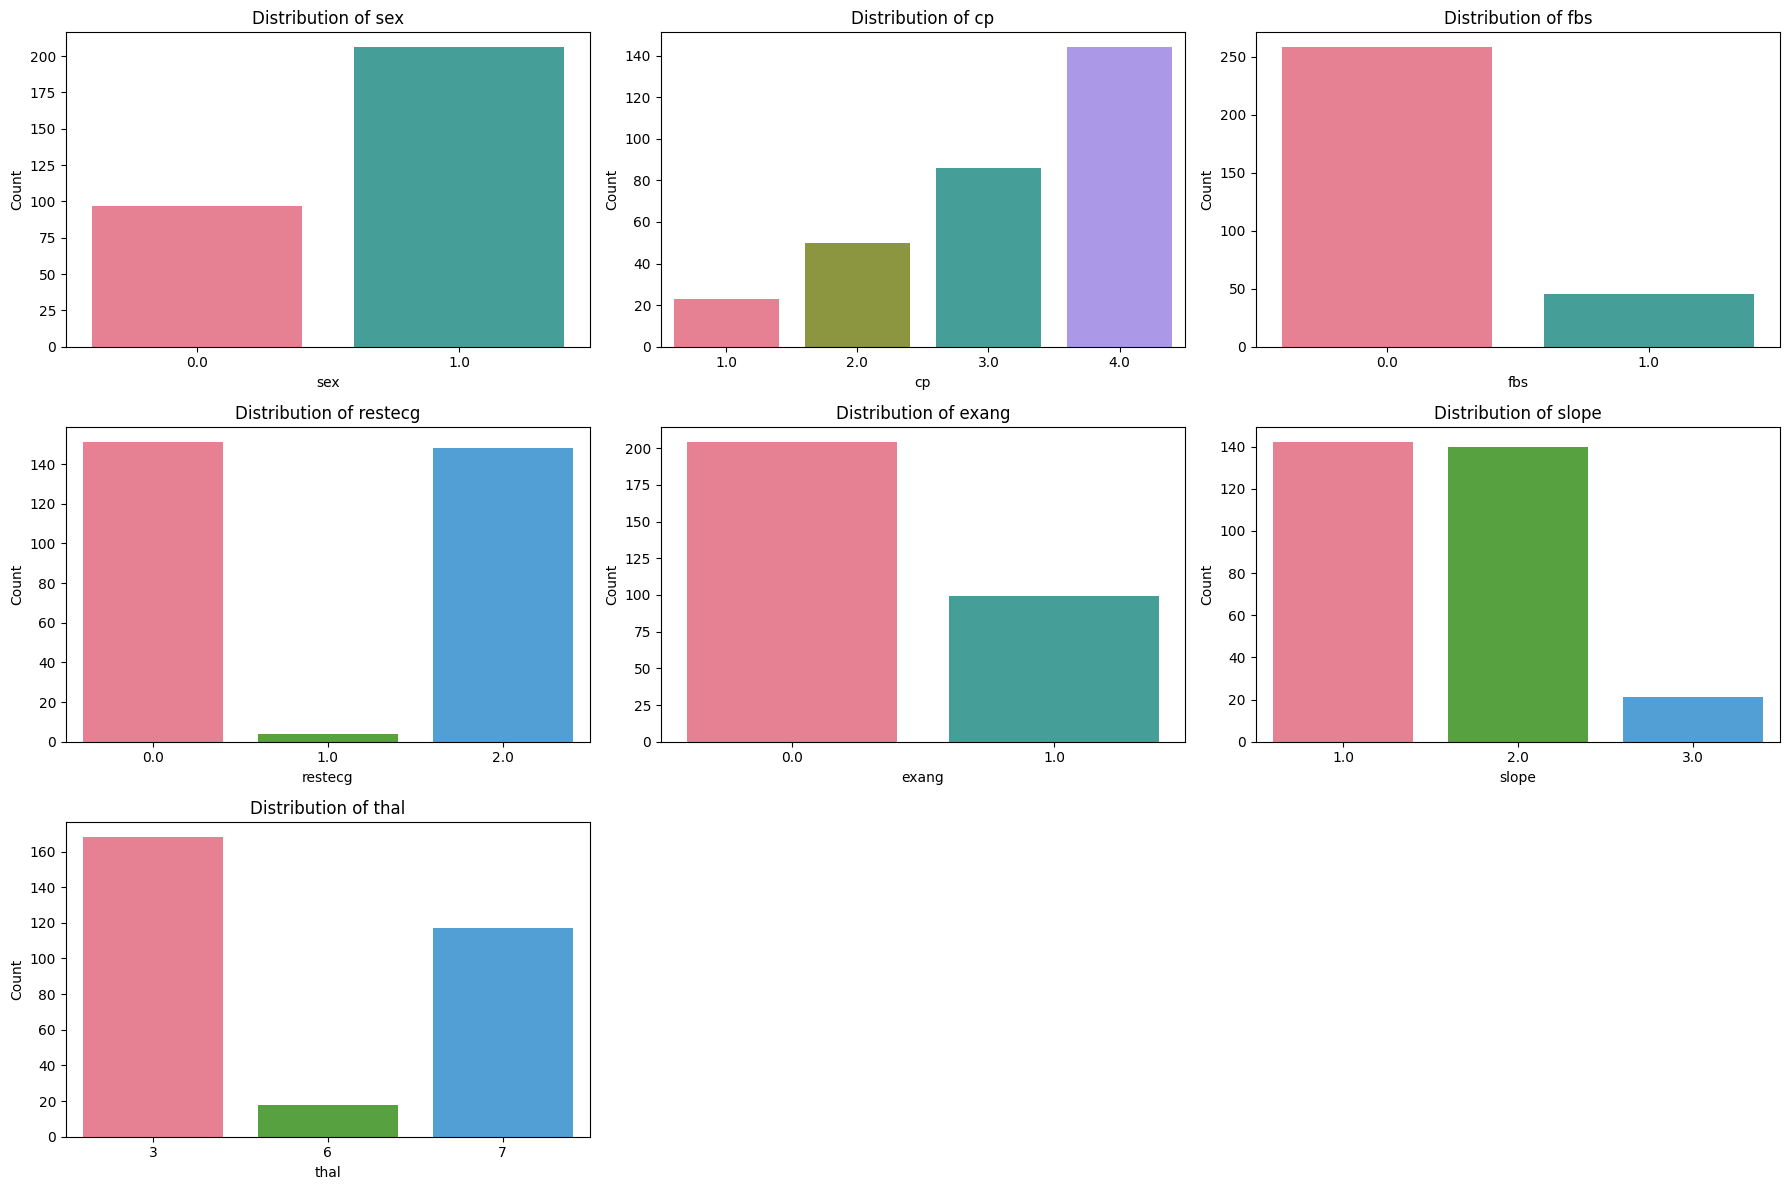

In [26]:
# Convert categorical columns to 'category' dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Set figure size
plt.figure(figsize=(18, 12))

# Plot countplots using the recommended 'hue' and disable legend
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=col, hue=col, palette='husl', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

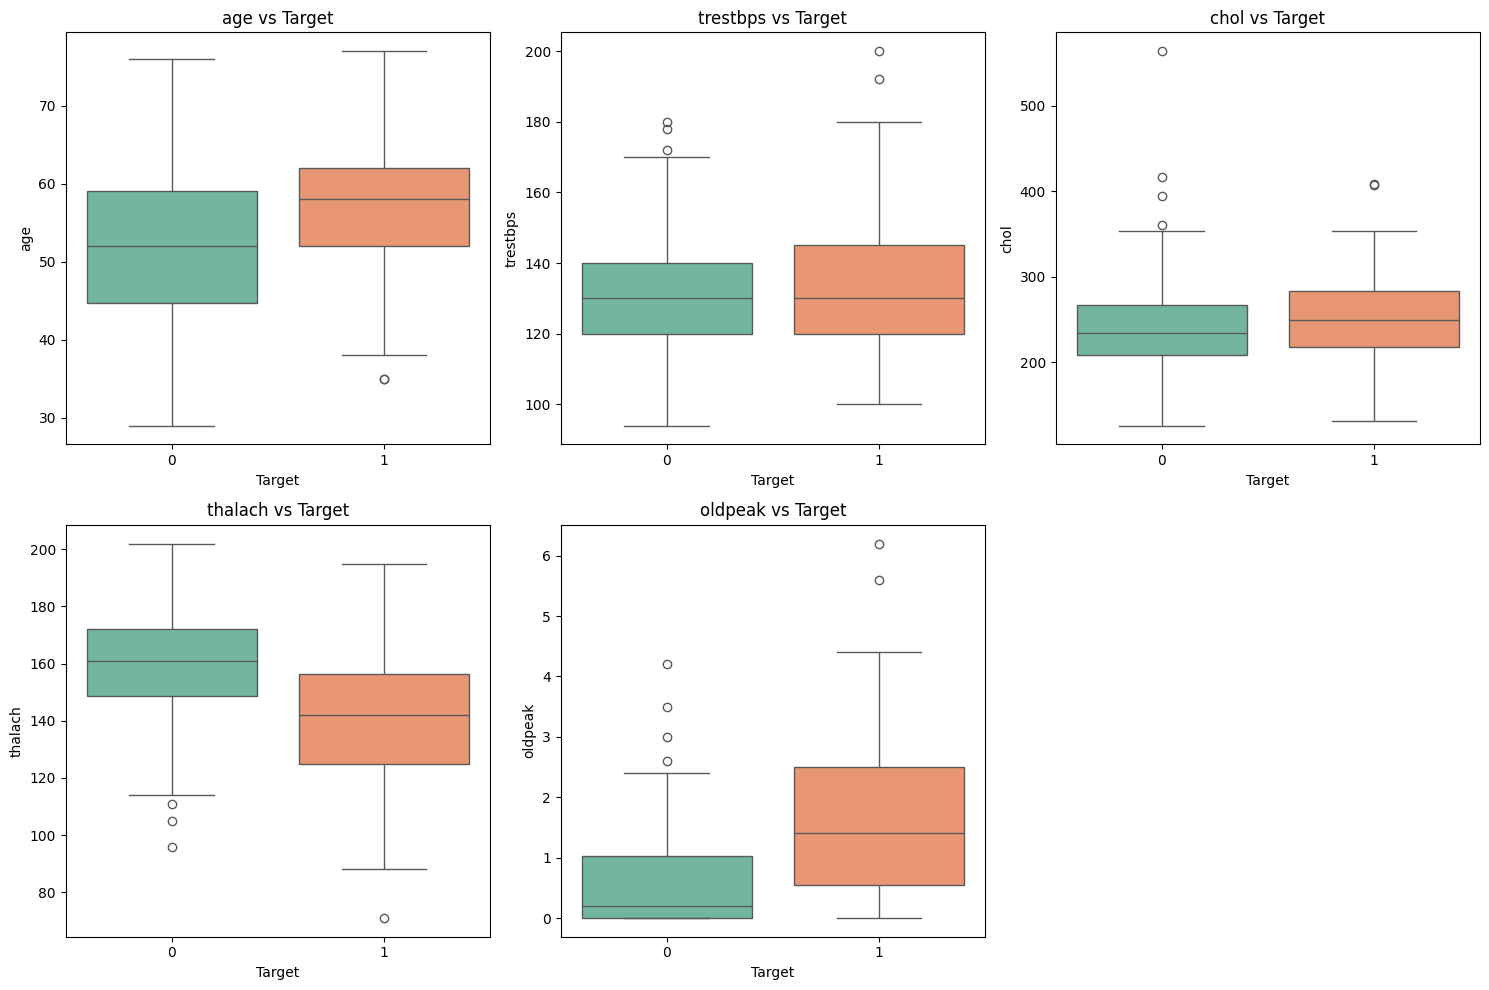

In [27]:
# List of numerical columns (excluding target variable)
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create subplots for numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot boxplots for numerical features vs target, using hue correctly
for ax, col in zip(axes, numerical_columns):
    sns.boxplot(x='target', y=col, data=data, hue='target', palette='Set2', ax=ax, legend=False)
    ax.set_title(f'{col} vs Target')
    ax.set_xlabel('Target')
    ax.set_ylabel(col)
    ax.legend_.remove() if ax.get_legend() else None  # Explicitly remove legend if present

# Remove the extra subplot (if any)
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [28]:
print(data.dtypes)

age          float64
sex         category
cp          category
trestbps     float64
chol         float64
fbs         category
restecg     category
thalach      float64
exang       category
oldpeak      float64
slope       category
ca             int64
thal        category
target         int64
dtype: object


In [29]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
data[categorical_columns] = data[categorical_columns].astype('category')

In [30]:
data.describe(include=['category'])

,sex,cp,fbs,restecg,exang,slope,thal
count,303.0,303.0,303.0,303.0,303.0,303.0,303
unique,2.0,4.0,2.0,3.0,2.0,3.0,3
top,1.0,4.0,0.0,0.0,0.0,1.0,3
freq,206.0,144.0,258.0,151.0,204.0,142.0,168


In [31]:
data.describe(exclude=['category'])

,age,trestbps,chol,thalach,oldpeak,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.663366,0.458746
std,9.038662,17.599748,51.776918,22.875003,1.161075,0.934375,0.499120
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000


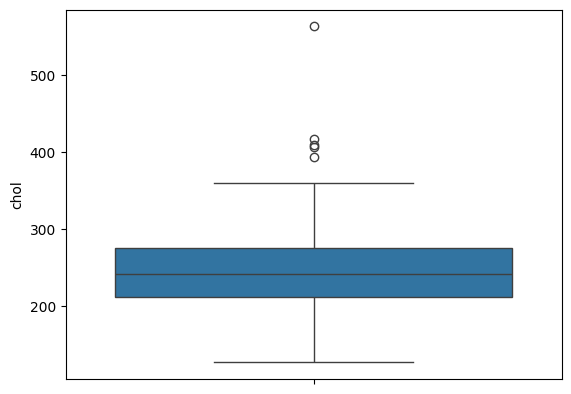

In [32]:
sns.boxplot(data=data['chol'])
plt.show()

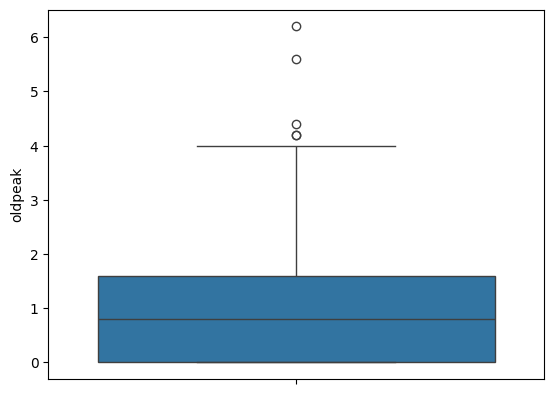

In [33]:
sns.boxplot(data=data['oldpeak'])
plt.show()

In [34]:
# Replace zeros with NaN
data['chol'] = data['chol'].replace(0, np.nan)

# Calculate median of 'chol' column (ignoring NaNs)
chol_median = data['chol'].median()

# Fill NaN values with calculated median
data['chol'] = data['chol'].fillna(chol_median)


In [35]:
# Replace zeros with NaN in 'oldpeak'
data['oldpeak'] = data['oldpeak'].replace(0, np.nan)

# Calculate median of 'oldpeak' (ignoring NaNs)
oldpeak_median = data['oldpeak'].median()

# Fill NaN values in 'oldpeak' with median
data['oldpeak'] = data['oldpeak'].fillna(oldpeak_median)


In [36]:
columns_with_outliers = ['chol', 'oldpeak']

for column in columns_with_outliers:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate median for the current column
    median = data[column].median()

    # Replace outliers with the median
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = median

# Display the updated dataset
print("Outliers replaced with median values.")

Outliers replaced with median values.


In [37]:
data.describe()

,age,trestbps,chol,thalach,oldpeak,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,243.438944,149.607261,1.249175,0.663366,0.458746
std,9.038662,17.599748,44.689533,22.875003,0.493525,0.934375,0.499120
min,29.000000,94.000000,126.000000,71.000000,0.100000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,1.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,1.400000,0.000000,0.000000
75%,61.000000,140.000000,273.000000,166.000000,1.400000,1.000000,1.000000
max,77.000000,200.000000,360.000000,202.000000,2.500000,3.000000,1.000000


<Axes: >

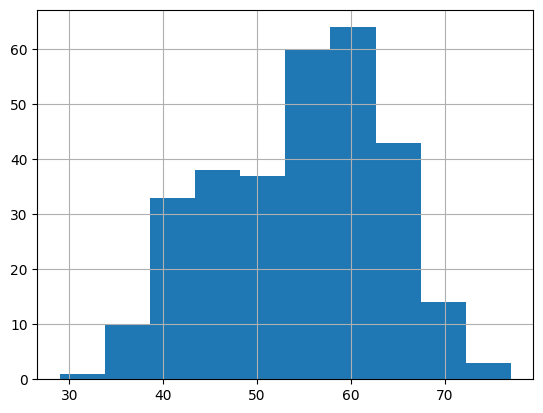

In [38]:
data["age"].hist()

In [39]:
# Adjust bins to match the number of labels
data['AGE_CATEGORY'] = pd.cut(data['age'], bins=[30, 50, 60, 70], labels=['New', 'Medium', 'Old'])

In [40]:
#Drop rows with NaN values in 'AGE_CATEGORY'
data = data.dropna(subset=['AGE_CATEGORY'])

# Apply LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['AGE_CATEGORY'])

# Display the encoded labels
print(encoded_labels)

[2 2 2 1 1 0 2 0 2 0 0 0 0 1 0 0 1 0 1 1 2 0 0 0 0 1 0 2 1 1 2 0 2 0 1 1 1
 0 0 2 2 1 0 2 0 0 1 2 0 1 2 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 2 2 2 2 1
 2 0 0 1 0 1 0 1 2 0 1 1 0 0 0 2 2 2 1 2 0 0 0 0 1 1 1 0 1 0 0 0 2 1 2 0 0
 1 2 1 0 1 2 2 1 2 0 0 2 1 0 0 1 2 0 0 0 1 0 2 2 1 0 0 0 0 2 0 1 0 1 1 0 0
 1 2 0 2 2 0 0 0 2 1 0 0 1 0 0 0 1 1 2 0 0 2 2 0 0 0 1 0 1 0 1 0 0 2 1 2 0
 2 1 0 1 2 2 2 2 1 1 0 1 2 0 2 1 1 0 1 0 2 1 1 1 2 0 0 1 1 2 0 1 0 1 0 2 1
 1 2 0 2 0 0 1 0 0 0 1 1 1 1 1 1 2 0 2 0 1 0 2 0 0 2 0 1 1 2 2 0 1 0 0 1 2
 1 0 0 1 1 2 2 1 0 2 2 1 0 0 0 1 0 1 2 0 0 0 0 0 2 0 1 2 2 1 0 0 1 2 0 0 1]


In [41]:
data['AGE_CATEGORY_label_encoded'] = encoded_labels

In [42]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AGE_CATEGORY,AGE_CATEGORY_label_encoded
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,6,0,Old,2
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3,3,1,Old,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,1.4,2.0,2,7,1,Old,2
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,1.4,3.0,0,3,0,New,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,3,0,New,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0,7,1,New,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,1.4,2.0,2,7,1,Old,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1,7,1,Medium,0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,1.4,2.0,1,3,1,Medium,0


In [43]:
data['AGE_CATEGORY']

0         Old
1         Old
2         Old
3         New
4         New
        ...  
298       New
299       Old
300    Medium
301    Medium
302       New
Name: AGE_CATEGORY, Length: 296, dtype: category
Categories (3, object): ['New' < 'Medium' < 'Old']

In [44]:
data['AGE_CATEGORY'].describe()

count        296
unique         3
top       Medium
freq         130
Name: AGE_CATEGORY, dtype: object

<Axes: >

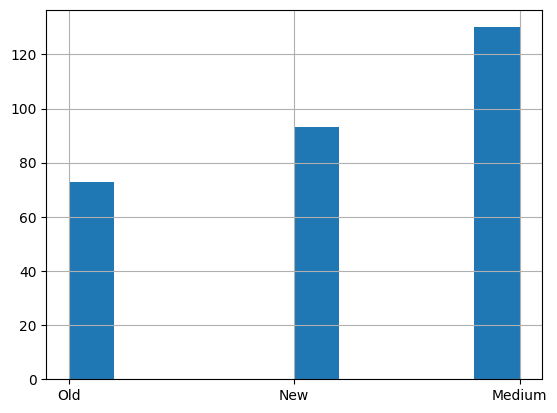

In [45]:
data['AGE_CATEGORY'].hist()

In [46]:
# Group data by categorical column 'AGEGROUP' with observed=True explicitly set
grouped_summary = data.groupby('AGE_CATEGORY', observed=True)['age'].describe()

# Display the summary statistics
print(grouped_summary)

              count       mean       std   min    25%   50%   75%   max
AGE_CATEGORY                                                           
New            93.0  43.612903  4.075463  34.0  41.00  44.0  47.0  50.0
Medium        130.0  55.761538  2.860595  51.0  53.25  56.0  58.0  60.0
Old            73.0  64.671233  2.614356  61.0  62.00  64.0  67.0  70.0


In [47]:
# One Hot Encoding
data_encoded = pd.get_dummies(data, columns=['AGE_CATEGORY'],dtype=int)
data_encoded

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AGE_CATEGORY_label_encoded,AGE_CATEGORY_New,AGE_CATEGORY_Medium,AGE_CATEGORY_Old
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,6,0,2,0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3,3,1,2,0,0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,1.4,2.0,2,7,1,2,0,0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,1.4,3.0,0,3,0,1,1,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,3,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0,7,1,1,1,0,0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,1.4,2.0,2,7,1,2,0,0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1,7,1,0,0,1,0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,1.4,2.0,1,3,1,0,0,1,0


<Figure size 1000x600 with 0 Axes>

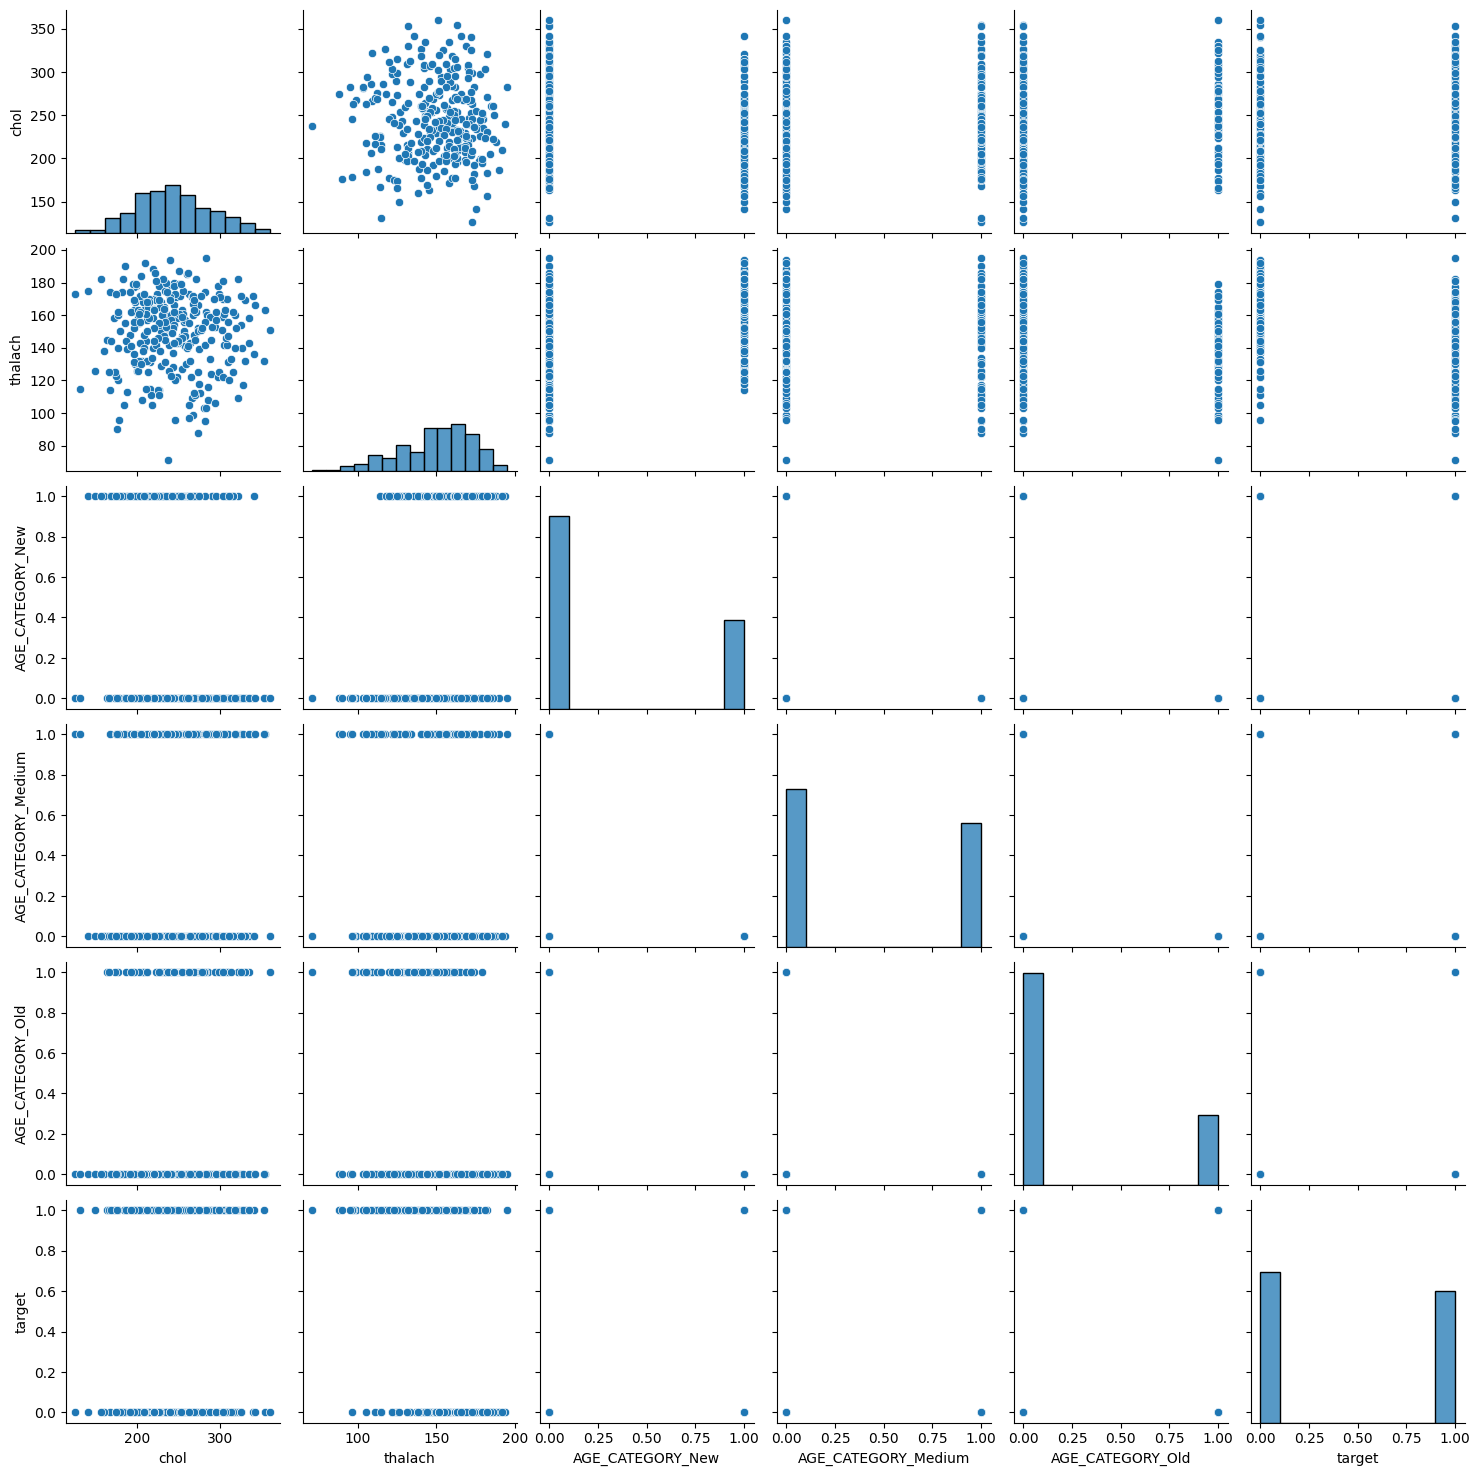

In [48]:
selected_features = ['chol', 'thalach', 'AGE_CATEGORY_New', 'AGE_CATEGORY_Medium', 'AGE_CATEGORY_Old', 'target']
data_selected = data_encoded[selected_features]

plt.figure(figsize=(10, 6))
sns.pairplot(data_selected)
plt.show()

In [49]:
print(data.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'AGE_CATEGORY',
       'AGE_CATEGORY_label_encoded'],
      dtype='object')


In [50]:
data = data.drop(['AGE_CATEGORY', 'AGE_CATEGORY_label_encoded'], axis=1)

## Feature Selection

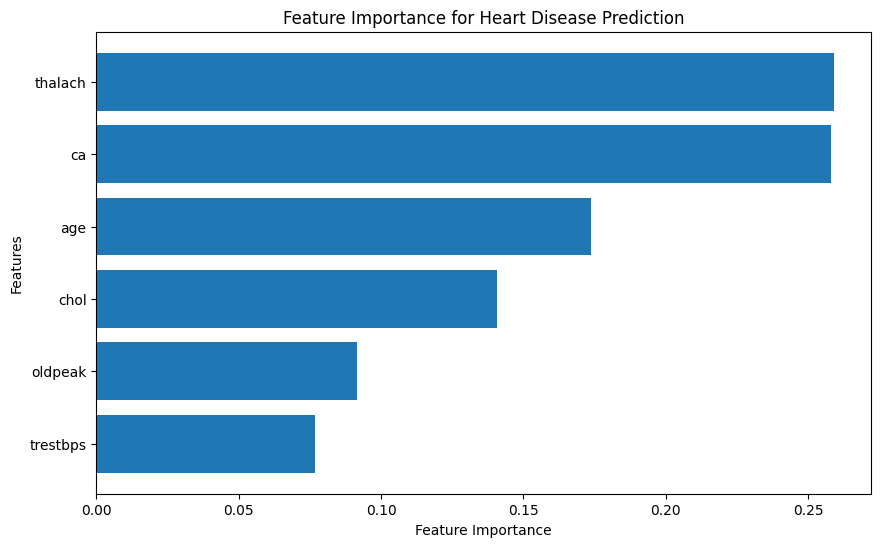

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


# Select numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
X = data[numerical_columns].drop('target', axis=1)  # Exclude the target variable
y = data['target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Heart Disease Prediction")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


Selected Features: ['thalach', 'ca']
Model accuracy after feature selection: 0.75


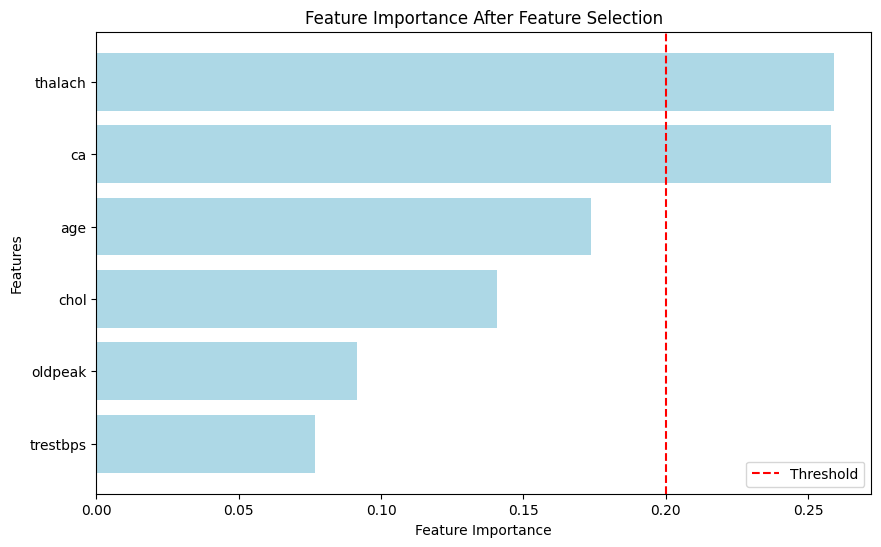

In [52]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Select numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
X = data[numerical_columns].drop('target', axis=1)  # Exclude the target variable
y = data['target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Define an importance threshold
threshold = 0.2  # Remove features with importance less than 0.02
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

print("Selected Features:", important_features)

# Create a new dataset with selected features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Retrain the model with selected features
model_selected = DecisionTreeClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train)

# Evaluate the new model
y_pred = model_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("Model accuracy after feature selection:", accuracy)

# Visualize the selected feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance After Feature Selection")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()


## Training and Evaluating Models

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
X = data[numerical_columns].drop('target', axis=1)  # Exclude the target variable
y = data['target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Train Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Feature Importance
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Predict and Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy with Min-Max Scaling:", accuracy)

Model Accuracy with Min-Max Scaling: 0.6666666666666666


                    Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0     Logistic Regression  0.750000   0.789474  0.576923  0.666667  0.814480
3  Support Vector Machine  0.733333   0.708333  0.653846  0.680000  0.824661
2           Random Forest  0.700000   0.642857  0.692308  0.666667  0.781109
4     k-Nearest Neighbors  0.683333   0.640000  0.615385  0.627451  0.680995
1           Decision Tree  0.666667   0.625000  0.576923  0.600000  0.656109


<Figure size 1000x600 with 0 Axes>

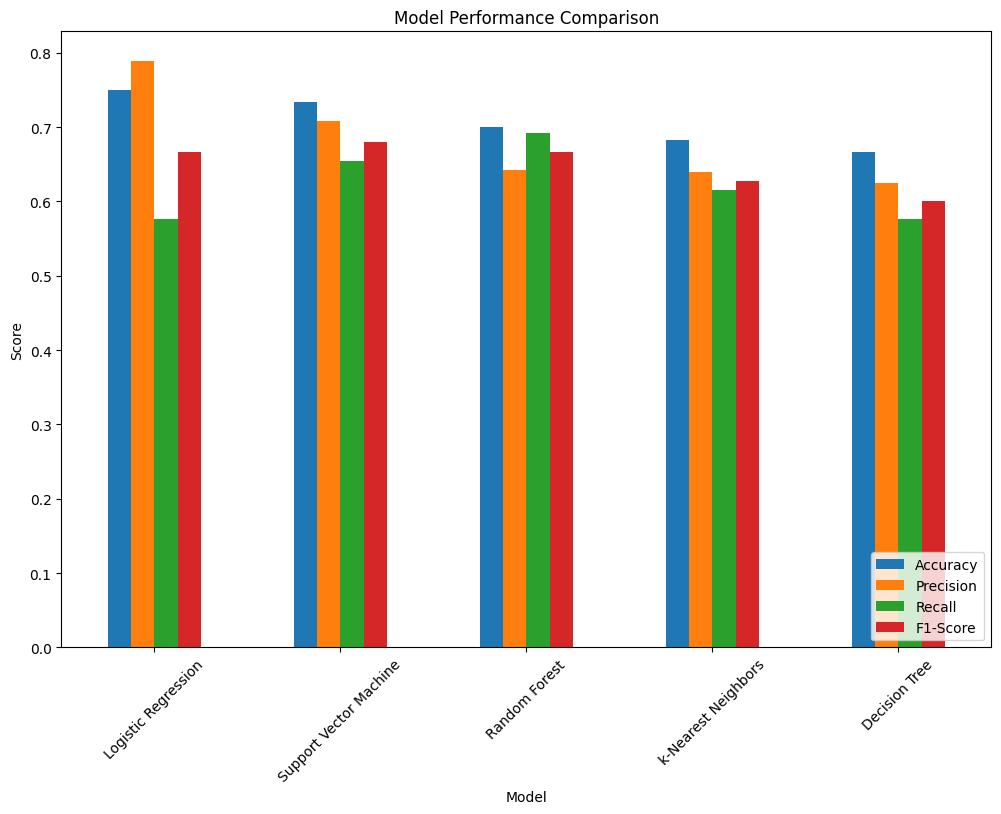

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
import matplotlib.pyplot as plt


# Step 1: Prepare the data
# Select numerical columns (assuming 'target' is one of them)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
X = data[numerical_columns].drop('target', axis=1)
y = data['target']

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier()
}

# Step 3: Train and Evaluate Models
results = []

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })

# Step 4: Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)

# Step 5: Visualize the results
plt.figure(figsize=(10, 6))
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(12, 8))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


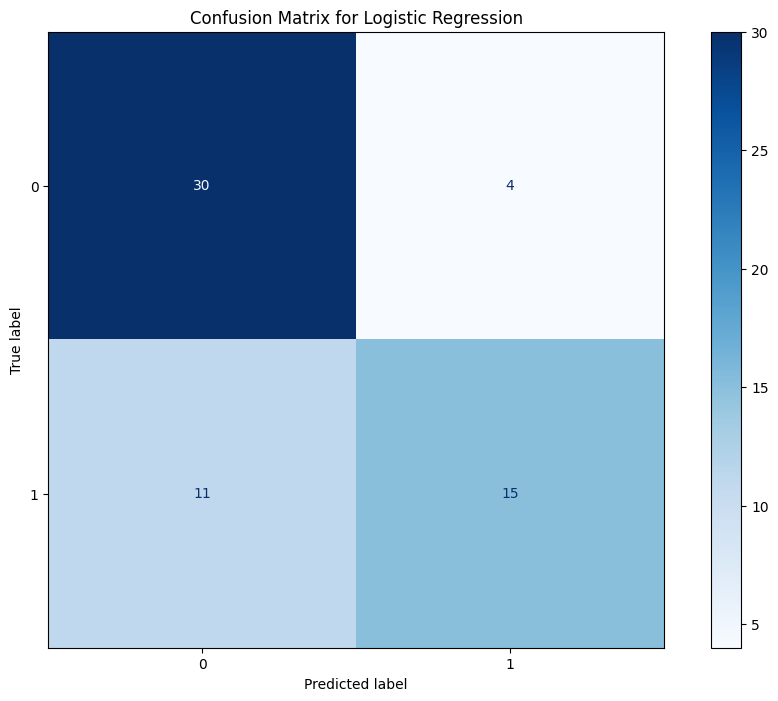

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80        34
           1       0.79      0.58      0.67        26

    accuracy                           0.75        60
   macro avg       0.76      0.73      0.73        60
weighted avg       0.76      0.75      0.74        60

Accuracy: 0.75


In [55]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt


# Step 1: Prepare the data
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
X = data[numerical_columns].drop('target', axis=1)  # Exclude the target variable
y = data['target']

# Scale the data using Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Train Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Step 3: Make Predictions
y_pred = logistic_model.predict(X_test)

# Step 4: Generate the Confusion Matrix with Larger Size
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))  # Set figure size
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
cmd.plot(cmap="Blues", values_format="d", ax=ax)  # Pass `ax` to increase size
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Step 5: Print Classification Report and Accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))